<p style="font-weight:bold; letter-spacing: 2px; color:#F5F5DC; font-size:140%; text-align:left; max-width: 1050px; padding: 10px; border-bottom: 3px solid #D2B48C"> Random Forest Classification</p>

*Import Libraries*

In [1]:
# import custom classes, functions and variables. Reload file in to memory on cell excution.
import importlib
import settings
importlib.reload(settings)

# import data frameworks
import pandas as pd
import numpy as np

# import viz
import matplotlib.pyplot as plt
import seaborn as sns

# import ML
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as Pipeline_imb
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
import statsmodels.api as sm
from imblearn.over_sampling import SMOTENC


# import others
import os
import pickle
import warnings

In [2]:
# Specific warning categories to be ignored
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

*Approach*
1. Load data
2. Split data
3. Create ColumnTransformer w/ ohe (so scaling needed)
4. Create RandomForestClassifier w/ default
5. Create pipeline w/ ColumnTransformer & RandomForestClassifier
6. Create and evaluate cross_val_score on pipeline
7. Compare train and test scores for baseline model (overfitting? Train likely ~ 100%)
8. Visualise affect of different seeds on baseline model.
9. Create GridSearchCV with params 
10. Fit and evaluate best hyperparameters
11. Plot classification_report and confusion_matrix
12. Evaluate affect of balancing the class with smote or with class_weight="balanced"
13. ????Visualise the best performing model with sklearn.tree.plot_tree 
14. Select k most important features and evaluate re-run with just those


*Import data from initial EDA*

In [3]:
df = pd.read_csv(os.path.join(settings.DATA_EDA_DIR, settings.DATA_EDA_FILE), sep=",")
if len(df) > 0:
    print("df loaded")

df loaded


*Split data and prepare labels*

In [7]:
ALL_FEATURES = ['Gender', 'Age', 'Occupation', 'Sleep Duration', 'Quality of Sleep', 
                'Physical Activity Level', 'Stress Level', 'BMI Category', 'Heart Rate', 
                'Daily Steps', 'Blood Pressure Category']
X = df[ALL_FEATURES]
y = df[settings.LABEL]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Encode y vector 
map = {"None":0, "Sleep Apnea":1, "Insomnia":2}
# apply mapping function
settings.column_mapper(y_train, "Sleep Disorder", map)
settings.column_mapper(y_test, "Sleep Disorder", map)

# # check new values in consolidated column
# display(settings.examine_values(y_train).loc["Sleep Disorder",:])
# display(settings.examine_values(y_train).loc["Sleep Disorder",:])

# reshape labels to 1-D array (vector) 
y_train, y_test = y_train.values.reshape(-1), y_test.values.reshape(-1)

*Preprocess steps*

In [10]:
# Create a column transformer for ohe and scaling
column_trans = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'), X_train.select_dtypes(include=['object']).columns)
    ],
    remainder='passthrough')

transformed_X_train_array = column_trans.fit_transform(X_train)
transformed_X_test_array = column_trans.transform(X_test)

# Convert to df as a sense check. Use only for interpretibility before using for pipeline. 
transformed_X_train_df = settings.convert_transformed_features_to_df(column_trans, transformed_X_train_array)
transformed_X_test_df = settings.convert_transformed_features_to_df(column_trans, transformed_X_test_array)

# Check ohe and scaled datasets
# display("train: check for dummy encoded columns and scaled values (mean 0 and std 1)",transformed_X_train_df.shape, transformed_X_train_df.describe().loc[["mean", "std"],:])
# display("test: check for same dummy encoded columns and scaled values (mean close to 0 and std close to 1)",transformed_X_test_df.shape, transformed_X_test_df.describe().loc[["mean", "std"],:])

*Create pipeline and base model*

In [7]:
# create model
model_dt = DecisionTreeClassifier(random_state=42)  # criterion ='gini' ["gini", "entropy", "log_loss"]
                                                    # splitter = 'best' ["best", "random"]
                                                    # max_depth = None [int]
                                                    # min_samples_split = 2 [int or float]
                                                    # min_samples_leaf = 1 [int or float]
                                                    # min_weight_fraction_leaf = 0.0 [float]
                                                    # max_features = None [int or float or "auto", "sqrt", "log2"]
                                                    # --> random_state = None
                                                    # max_leaf_nodes = None [int]
                                                    # min_impurity_decrease = 0.0 [float]
                                                    # class_weight = None [dict, list of dict or "balanced"]
                                                    # ccp_alpha = 0.0 [float]

# create sklearn pipeline
pipeline_dt = settings.create_pipeline(["preprocess", column_trans], ["decision_tree_classification", model_dt])

# create cross validation object for cross_val_score
cv_dt = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

# run training cross validation on pipeline 
cv_scores = cross_val_score(pipeline_dt, X_train, y_train, scoring='accuracy', cv=cv_dt)

settings.cross_val_summary(pipeline_dt, cv_scores, X_train, y_train, X_test, y_test)


Train Accuracy: 92.700 %
Mean CV Train Accuracy: 86.6100 % ( +- 4.600 % )
Test Accuracy: 90.2700 %


Average train score across seeds: 93.500 %
Average cv train score across seeds: 87.000 %
Average test score across seeds: 88.000 %
seed closest to average: 22  (difference:  0.200 % )


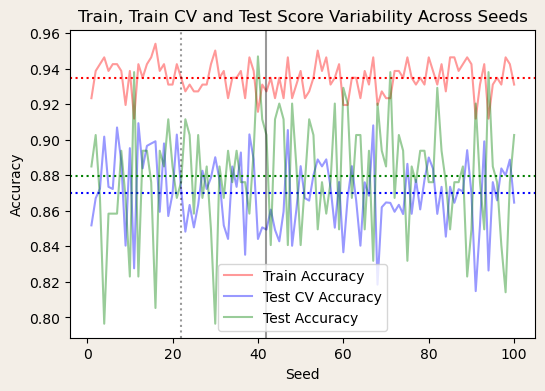

In [7]:
# Visualise averages across many seeds
settings.plot_seed_variability(X=X, y=y, test_size=0.3, current_seed=42, num_seeds=100, pipeline_or_model=pipeline_dt, scoring="accuracy", cv_object=cv_dt)

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left; max-width: 1050px; margin: 0 auto; color: #444444;">

<h3 align="left"><font color='#DEB887'>💡 Insights:</font></h3>

<ul>
    <li>High baseline model train cv accuracy 86.6% but much higher test accuracy 90.3%, close to train accuracy of 92.7%.</li>
    <li>High variation in cv accuracy scores: 4.6%</li>     
    <li>Seed variability plot shows impact of seed: 42, by chance, produces above average test accuracy score.</li>
    <li>High dependance on data split which itself depends on the random seed: reason for higher test accuracy in the first case. As seen in the last graph, varying the random seed 100 times results in occassions where test score is much higher than the average (88.0%). On average, model shows signs of slight overfitting but large variation in test scores cast the reliability in to doubt. Train CV scores, even with their high variation, provide a more stable assessment.</li>
    <li>Goal will be to maximise Train CV scores and reduce variation. Test score will be evaluated as an additional step but not used for model selection. 
</ul>
</div>


In [8]:
# Save baseline pipeline to file  
settings.save_pipeline("best_decision_tree_classification_pipeline.pkl", pipeline_dt)

*Hyperparam tuning*

*Impurity and split method*

In [9]:
# set up param grid
param_grid_dt = {
    'decision_tree_classification__criterion': ["gini", "entropy"],
    'decision_tree_classification__splitter': ["best", "random"], 
}

# Create and fit GridSearchCV object on train data
grid_search_dt = GridSearchCV(pipeline_dt, param_grid=param_grid_dt, scoring='accuracy', cv=cv_dt, n_jobs=-1)
grid_search_dt.fit(X_train, y_train)

settings.hyperparam_tune_summary(grid_search_dt, X_train, y_train, X_test, y_test)

Best Parameters:


,decision_tree_classification__criterion,decision_tree_classification__splitter
0,gini,random


---------------------
Using best parameters
---------------------
Train Accuracy: 92.700 %
Mean CV Train Accuracy: 87.200 % ( +- 4.000 % )
Test Accuracy: 90.300 %


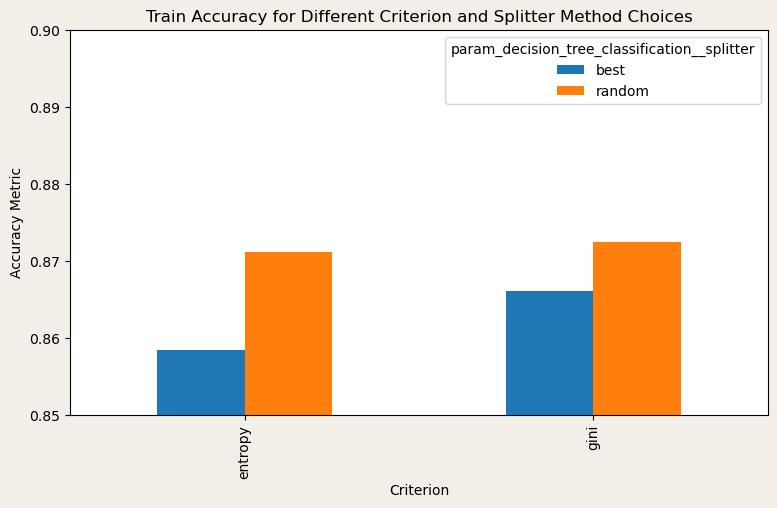

In [10]:
# Access the grid search results
results = grid_search_dt.cv_results_

# Extract k values, weights values and accuracy scores
grouped = pd.DataFrame(results)
grouped = grouped.groupby(["param_decision_tree_classification__criterion", "param_decision_tree_classification__splitter"])["mean_test_score"].mean().unstack()

# Plot the grouped bar chart
fig, ax = plt.subplots(figsize=(6, 4), gridspec_kw={'hspace': 0.8}, facecolor="#F3EEE7")
grouped.plot(kind='bar', figsize=(9, 5), ax=ax)

# Add plot details
ax.set_ylim(0.85, 0.9)
ax.set_xlabel('Criterion')
ax.set_ylabel('Accuracy Metric')
ax.set_title('Train Accuracy for Different Criterion and Splitter Method Choices')
plt.show()

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left; max-width: 1050px; margin: 0 auto; color: #444444;">

<h3 align="left"><font color='#DEB887'>💡 Insights:</font></h3>

<ul>
    <li>Criterion of entropy performs better  than gini</li>
    <li>When entropy chosen, random split slightly performs slightly better. This is where the split point for all attributes is randomly chosen (only for the continuous columns) rather than exhaustively finding the best threshold for the split point. The additional randomness introduced means that the same attribute will not always be chosen to split nodes in the tree and hense potentially more generalisability for unseen data is created. However, the difference is very minor.</li>
    <li>Compared to the standard deviation in the CV scores for this dataset (~4% in base model), differences are very small. All options will remain in further tuning.</li>
</ul>
</div>


*Pre pruning method*

In [11]:
# set up param grid
param_grid_dt = {
    'decision_tree_classification__criterion': ["gini", "entropy"],
    'decision_tree_classification__splitter': ["best", "random"], 
    'decision_tree_classification__max_depth': [None, 3, 5, 7],
    'decision_tree_classification__min_samples_split': [2, 5, 10],
    'decision_tree_classification__min_samples_leaf': [1, 5, 10],
    'decision_tree_classification__max_leaf_nodes': [None, 5, 10],
}

# Create and fit GridSearchCV object on train data
grid_search_dt = GridSearchCV(pipeline_dt, param_grid=param_grid_dt, scoring='accuracy', cv=cv_dt, n_jobs=-1)
grid_search_dt.fit(X_train, y_train)

settings.hyperparam_tune_summary(grid_search_dt, X_train, y_train, X_test, y_test)

Best Parameters:


,decision_tree_classification__criterion,decision_tree_classification__max_depth,decision_tree_classification__max_leaf_nodes,decision_tree_classification__min_samples_leaf,decision_tree_classification__min_samples_split,decision_tree_classification__splitter
0,entropy,5,None,1,5,random


---------------------
Using best parameters
---------------------
Train Accuracy: 90.400 %
Mean CV Train Accuracy: 89.400 % ( +- 3.300 % )
Test Accuracy: 92.000 %


Average train score across seeds: 92.400 %
Average cv train score across seeds: 88.700 %
Average test score across seeds: 89.000 %
seed closest to average: 58  (difference:  0.300 % )


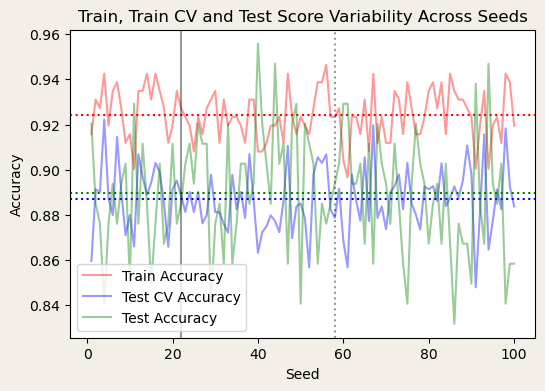

In [ ]:
# Visualise averages across many seeds
settings.plot_seed_variability(X=X, y=y, test_size=0.3, current_seed=22, num_seeds=100, pipeline_or_model=best_pipeline, scoring="accuracy", cv_object=cv_dt)

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left; max-width: 1050px; margin: 0 auto; color: #444444;">

<h3 align="left"><font color='#DEB887'>💡 Insights:</font></h3>

<ul>
    <li>Grid search of hyperparamters involved in pre-pruning has improved train CV accuracy by 1.8%.</li>
    <li>Variation in CV scores has dropped to a std of 3.3%</li>
    <li>Overfitting has been reduced</li>
    <li>Entropy and random have been reproduced as best hyperparameters, will stick with these. Ranges for others will be honed.</li>
</ul>
</div>


In [13]:
# SAVE BASED ON CV SCORE

# collect candidate tuned pipeline and CV score 
best_pipeline = grid_search_dt.best_estimator_
best_cv_score = grid_search_dt.best_score_

# collect current (saved) best pipeline and CV score
current_best_pipeline = settings.get_saved_pipeline("best_decision_tree_classification_pipeline.pkl")
current_best_pipeline_mean_cv = np.mean(cross_val_score(current_best_pipeline, X_train, y_train, scoring='accuracy', cv=cv_dt))

# overwrite with candidate if CV score is higher
if best_cv_score > current_best_pipeline_mean_cv:
    settings.save_pipeline("best_decision_tree_classification_pipeline.pkl", best_pipeline)

*Hone in on promising ranges*

In [ ]:
# # refine model
# model_dt = DecisionTreeClassifier(criterion="entropy", splitter="random", random_state=42)

# # create sklearn pipeline
# pipeline_dt = settings.create_pipeline(["preprocess", column_trans], ["decision_tree_classification", model_dt])

# # set up param grid
# param_grid_dt = {
#     'decision_tree_classification__max_depth': [None, 1, 2, 3, 4],
#     'decision_tree_classification__min_samples_split': [7, 8, 9, 10, 11, 12],
#     'decision_tree_classification__min_samples_leaf': [1, 2, 3, 4, 5],
#     'decision_tree_classification__max_leaf_nodes': [None, 3, 4, 5, 6, 7]
# }

# # Create and fit GridSearchCV object on train data
# grid_search_dt = GridSearchCV(pipeline_dt, param_grid=param_grid_dt, scoring='accuracy', cv=cv_dt, n_jobs=-1)
# grid_search_dt.fit(X_train, y_train)

# settings.hyperparam_tune_summary(grid_search_dt, X_train, y_train, X_test, y_test)

In [ ]:
# # Visualise averages across many seeds
# settings.plot_seed_variability(X=X, y=y, test_size=0.3, current_seed=22, num_seeds=100, pipeline_or_model=best_pipeline, scoring="accuracy", cv_object=cv_dt)

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left; max-width: 1050px; margin: 0 auto; color: #444444;">

<h3 align="left"><font color='#DEB887'>💡 Insights:</font></h3>

<ul>
    <li>Improvement in Train CV but decrease in test accuracy</li>
    <li>Furthermore, we see that on average across seeds, no gain is reported in any of the scores. As such, the improvement in train CV score with new parameters isn't reflective of improvement.</li>
</ul>
</div>


*Post pruning*

In [14]:
pipeline_dt = settings.get_saved_pipeline("best_decision_tree_classification_pipeline.pkl")

# set up param grid
param_grid_dt = {
    'decision_tree_classification__ccp_alpha': np.linspace(0,10,11)
}

# Create and fit GridSearchCV object on train data
grid_search_dt = GridSearchCV(pipeline_dt, param_grid=param_grid_dt, scoring='accuracy', cv=cv_dt, n_jobs=-1)
grid_search_dt.fit(X_train, y_train)

settings.hyperparam_tune_summary(grid_search_dt, X_train, y_train, X_test, y_test)

Best Parameters:


,decision_tree_classification__ccp_alpha
0,0.0


---------------------
Using best parameters
---------------------
Train Accuracy: 90.400 %
Mean CV Train Accuracy: 89.400 % ( +- 3.300 % )
Test Accuracy: 92.000 %


<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left; max-width: 1050px; margin: 0 auto; color: #444444;">

<h3 align="left"><font color='#DEB887'>💡 Insights:</font></h3>

<ul>
    <li>Post pruning does not increase train CV accuracy nor test accuracy</li>
    <li>Post pruning was also run on the baseline model and did not increase any accuracy</li>
</ul>
</div>


*Addressing Class Imbalance: Exploring hyperparameter and SMOTE-NC*

In [15]:
pipeline_dt = settings.get_saved_pipeline("best_decision_tree_classification_pipeline.pkl")

# set up param grid
param_grid_dt = {
    'decision_tree_classification__class_weight': ["balanced"] 
}

# Create and fit GridSearchCV object on train data
grid_search_dt = GridSearchCV(best_pipeline, param_grid=param_grid_dt, scoring='accuracy', cv=cv_dt, n_jobs=-1)
grid_search_dt.fit(X_train, y_train)

settings.hyperparam_tune_summary(grid_search_dt, X_train, y_train, X_test, y_test)


Best Parameters:


,decision_tree_classification__class_weight
0,balanced


---------------------
Using best parameters
---------------------
Train Accuracy: 90.400 %
Mean CV Train Accuracy: 87.000 % ( +- 4.100 % )
Test Accuracy: 90.300 %


In [16]:
# instantiate SMOTENC object with categorical indicies of transformed X_train dataset
categorical_features = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
smote_nc = SMOTENC(categorical_features=categorical_features, random_state=42)

# Proving smote object works using the X array transformed by column_trans
from collections import Counter
smote_x, smote_y = smote_nc.fit_resample(transformed_X_train_df, y_train)
print(f"Original class counts: {Counter(y_train)}")
print(f"New class counts: {Counter(smote_y)}")

Original class counts: Counter({0: 153, 2: 54, 1: 54})
New class counts: Counter({2: 153, 1: 153, 0: 153})


In [20]:
# get best model to insert in to imblearn's Pipeline class
pipeline_dt = settings.get_saved_pipeline("best_decision_tree_classification_pipeline.pkl")
model_dt = pipeline_dt.named_steps['decision_tree_classification']

# Set up pipeline using imblearn's Pipeline class (SMOTE not compatible with sklearn's Pipeline)
# Reuse model with tuned hyperparameters
steps = [('column_trans', column_trans), ('smote', smote_nc), ("decision_tree_classification", model_dt)]
pipeline_dt = Pipeline_imb(steps)

# Fit pipeline and produce training accuracy
pipeline_dt.fit(X_train, y_train)
train_acc = pipeline_dt.score(X_train, y_train)
print('Train Accuracy:', settings.score_formatter(train_acc, 3))

# run training cross validation on pipeline 
cv_scores = cross_val_score(pipeline_dt, X_train, y_train, scoring='accuracy', cv=cv_dt)

# Calculate mean and standard deviation of cross-validation train scores
mean_train_cv = np.mean(cv_scores)
std_train_cv = np.std(cv_scores)
print('Mean CV Train Accuracy:', settings.score_formatter(mean_train_cv, 4),
    "( +-", settings.score_formatter(std_train_cv, 3), ")")

# extract model (remove smote for test) and produce test score 
model_dt = pipeline_dt.named_steps['decision_tree_classification']
test_accuracy = model_dt.score(transformed_X_test_df.values, y_test)
print('Test Accuracy:', settings.score_formatter(test_accuracy, 3))

Train Accuracy: 91.600 %
Mean CV Train Accuracy: 89.1600 % ( +- 3.700 % )
Test Accuracy: 91.200 %


Average train score across seeds: 92.100 %
Average cv train score across seeds: 89.300 %
Average test score across seeds: 89.400 %
seed closest to average: 41  (difference:  0.100 % )


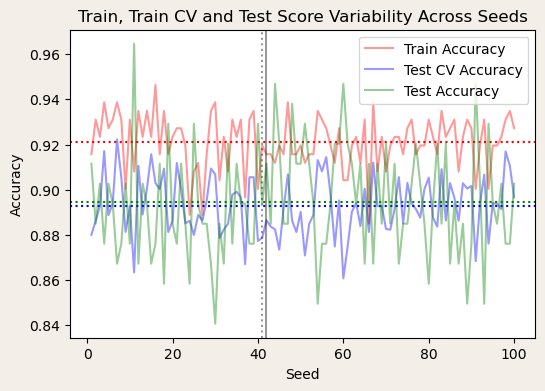

In [21]:
# Visualise averages across many seeds
settings.plot_seed_variability(X=X, y=y, test_size=0.3, current_seed=42, num_seeds=100, pipeline_or_model=pipeline_dt, scoring="accuracy", cv_object=cv_dt, pipeline_type = "imblearn")

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left; max-width: 1050px; margin: 0 auto; color: #444444;">

<h3 align="left"><font color='#DEB887'>💡 Insights:</font></h3>

<ul>
    <li>Using class_imbalance or SMOTE doesn't result in improvement in CV accuracy</li>
</ul>
</div>


*Review metrics for hypertuned model*

Test Accuracy: 92.000 %

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.96        66
           1       0.86      0.79      0.83        24
           2       0.88      0.91      0.89        23

    accuracy                           0.92       113
   macro avg       0.90      0.89      0.89       113
weighted avg       0.92      0.92      0.92       113



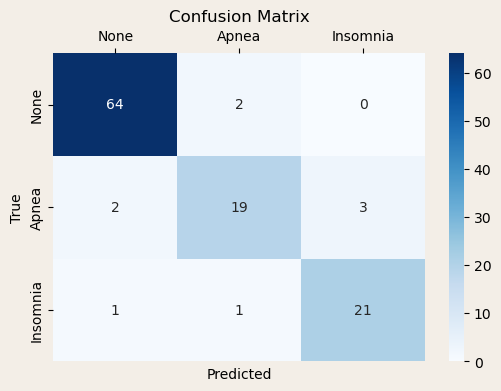

In [22]:
# Print test accuracy
pipeline_dt = settings.get_saved_pipeline("best_decision_tree_classification_pipeline.pkl")
model_dt = pipeline_dt.steps[-1][1]
test_accuracy = model_dt.score(transformed_X_test_df.values, y_test)
print('Test Accuracy:', settings.score_formatter(test_accuracy, 3))

# Generate prediction and show classification report
y_pred = model_dt.predict(transformed_X_test_df.values)
class_report = classification_report(y_test, y_pred)
print("\nClassification Report:\n", class_report)

# Generate confusion matrix
class_labels = ["None","Apnea","Insomnia"]
conf_matrix = confusion_matrix(y_test, y_pred)

settings.plot_conf_matrix(class_labels, conf_matrix)

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left; max-width: 1050px; margin: 0 auto; color: #444444;">

<h3 align="left"><font color='#DEB887'>💡 Insights:</font></h3>

<ul>
    <li>Model best at predicting None, with a very high precision and recall at 94%</li>
    <li>Apnea has lower recall at 79% (5 incorrect out of test 24 instances) and high precision (86%)</li>
    <li>Insomnia has high recall at 91% (2 incorrect out of 23 instances) and very similar precision to Apnea (86%)</li>
</ul>
</div>


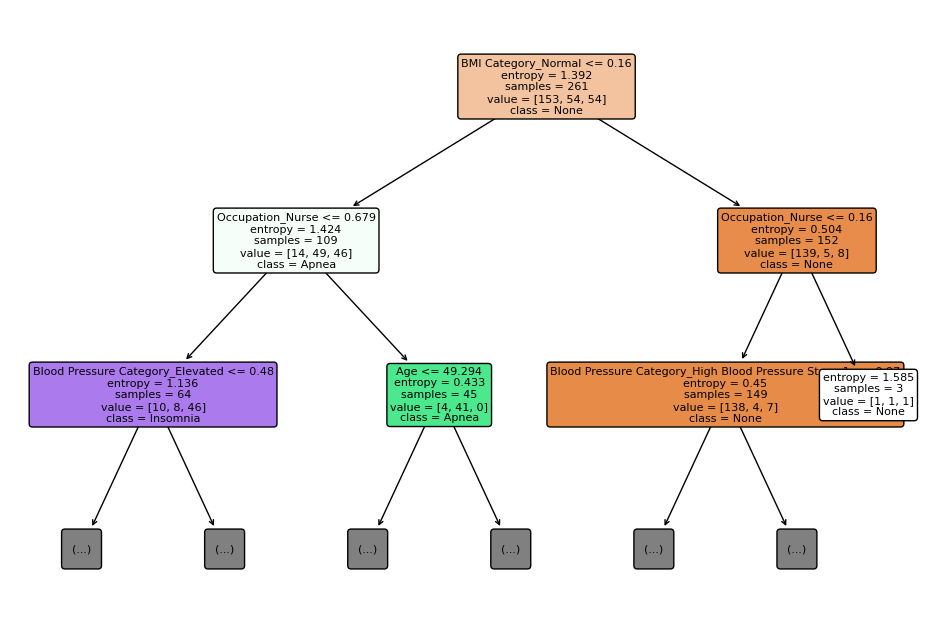

In [23]:
import matplotlib.pyplot as plt
from sklearn import tree

feature_names = transformed_X_train_df.columns
class_names = class_labels

# Create a larger figure for the plot
plt.figure(figsize=(12, 8))  # Adjust the width and height as needed

# Plot the decision tree
tree.plot_tree(model_dt, max_depth=2, feature_names=feature_names, class_names=class_names,
               filled=True, rounded=True, fontsize=8)  # Adjust fontsize as needed

# Show the plot
plt.show()


                             Feature  Importance
10               BMI Category_Normal    0.506840
6                   Occupation_Nurse    0.261157
22                       Daily Steps    0.083605
12  Blood Pressure Category_Elevated    0.073240
17                    Sleep Duration    0.013911


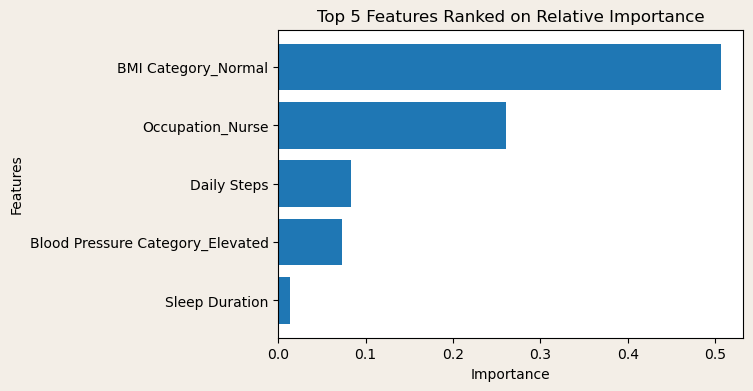

In [24]:
# Access feature importances
feature_importances = model_dt.feature_importances_

# Get feature names from your dataset (assuming they are in a list or array)
feature_names = np.array(feature_names)

# Create a DataFrame to display feature importances with corresponding names
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)[:5]
print(importance_df)

# Re sort for the barh plot
importance_df = importance_df.sort_values(by='Importance', ascending=True)

# Plot the grouped bar chart
fig, ax = plt.subplots(figsize=(6, 4), gridspec_kw={'hspace': 0.8}, facecolor="#F3EEE7")
ax.barh(importance_df.Feature, importance_df.Importance)
ax.set_xlabel("Importance")
ax.set_ylabel("Features")
ax.set_title("Top 5 Features Ranked on Relative Importance")
plt.show()